In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import warnings
warnings.filterwarnings("ignore")

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("altavish/boston-housing-dataset")

print("Path to dataset files:", path)

100%|██████████| 11.7k/11.7k [00:00<00:00, 7.73MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/altavish/boston-housing-dataset/versions/1


In [3]:
train_path = path + "/HousingData.csv"

# Load the training data
data = pd.read_csv(train_path)

# Explore the data
print("Data Head:\n", data.head())
print("\nData Info:\n")
data.info()
print("\nData Description:\n", data.describe())

Data Head:
       CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD  TAX  PTRATIO  \
0  0.00632  18.0   2.31   0.0  0.538  6.575  65.2  4.0900    1  296     15.3   
1  0.02731   0.0   7.07   0.0  0.469  6.421  78.9  4.9671    2  242     17.8   
2  0.02729   0.0   7.07   0.0  0.469  7.185  61.1  4.9671    2  242     17.8   
3  0.03237   0.0   2.18   0.0  0.458  6.998  45.8  6.0622    3  222     18.7   
4  0.06905   0.0   2.18   0.0  0.458  7.147  54.2  6.0622    3  222     18.7   

        B  LSTAT  MEDV  
0  396.90   4.98  24.0  
1  396.90   9.14  21.6  
2  392.83   4.03  34.7  
3  394.63   2.94  33.4  
4  396.90    NaN  36.2  

Data Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     486 non-null    float64
 1   ZN       486 non-null    float64
 2   INDUS    486 non-null    float64
 3   CHAS     486 non-null    float64
 4   NOX   

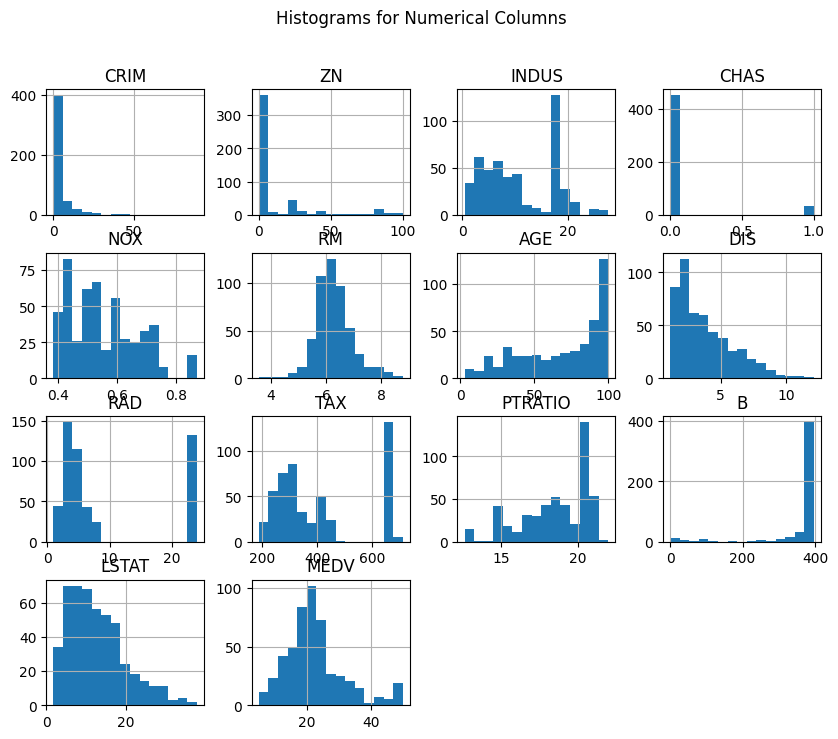

In [4]:
data.hist(bins=15, figsize=(10, 8))
plt.suptitle("Histograms for Numerical Columns")
plt.show()


In [5]:
# Step 4: Handle missing values (if any)
print("\nNumber of missing values before filling:")
print(data.isnull().sum())



Number of missing values before filling:
CRIM       20
ZN         20
INDUS      20
CHAS       20
NOX         0
RM          0
AGE        20
DIS         0
RAD         0
TAX         0
PTRATIO     0
B           0
LSTAT      20
MEDV        0
dtype: int64


In [6]:
# Handle missing values by filling with the mean for numerical columns
mean_values = data.mean(numeric_only=True)
data.fillna(mean_values, inplace=True)

In [7]:
# Check again for missing values after filling
print("\nNumber of missing values after filling:")
print(data.isnull().sum())


Number of missing values after filling:
CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64


In [8]:
# Step 5: Preprocess the data (Ensure there are no NaNs in features and target)
X = data.drop(columns=['CRIM'])  # Features
y = data['CRIM']  # Target variable

In [9]:
# Ensure there are no NaNs in features (X) and target (y)
if X.isnull().sum().any():
    print("Warning: There are missing values in the feature columns!")
else:
    print("No missing values in feature columns.")

if y.isnull().sum() > 0:
    print("Warning: There are missing values in the target column!")
else:
    print("No missing values in the target column.")

No missing values in feature columns.
No missing values in the target column.


In [10]:
# Step 6: Handle outliers using IQR (Interquartile Range)
outlier_columns = []
outliers_dict = {}

# Identifying outliers for each numeric column
for feature in data.select_dtypes(include=[np.number]).columns:
    Q1 = data[feature].quantile(0.25)
    Q3 = data[feature].quantile(0.75)
    IQR = Q3 - Q1  # Interquartile Range (difference between Q3 and Q1)
    outlier_mask = (data[feature] < (Q1 - 1.5 * IQR)) | (data[feature] > (Q3 + 1.5 * IQR))

    if outlier_mask.any():  # If there is at least one outlier
        outliers_dict[feature] = data[outlier_mask]  # Store outliers in the dictionary
        outlier_columns.append(feature)  # Add the feature name to the outlier_columns list


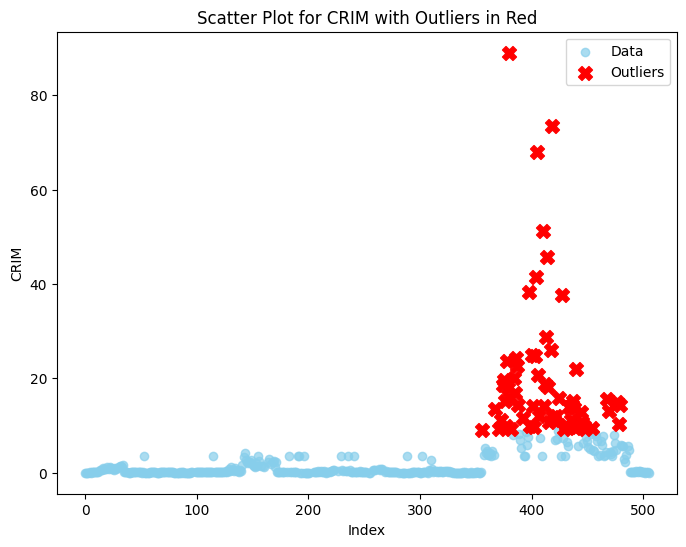


Outliers Detected for CRIM:
         CRIM   ZN  INDUS      CHAS    NOX     RM    AGE     DIS  RAD  TAX  \
356   8.98296  0.0   18.1  1.000000  0.770  6.212   97.4  2.1222   24  666   
367  13.52220  0.0   18.1  0.069959  0.631  3.863  100.0  1.5106   24  666   
371   9.23230  0.0   18.1  0.000000  0.631  6.216  100.0  1.1691   24  666   
373  11.10810  0.0   18.1  0.000000  0.668  4.906  100.0  1.1742   24  666   
374  18.49820  0.0   18.1  0.000000  0.668  4.138  100.0  1.1370   24  666   
..        ...  ...    ...       ...    ...    ...    ...     ...  ...  ...   
468  15.57570  0.0   18.1  0.000000  0.580  5.926   71.0  2.9084   24  666   
469  13.07510  0.0   18.1  0.000000  0.580  5.713   56.7  2.8237   24  666   
477  15.02340  0.0   18.1  0.000000  0.614  5.304   97.3  2.1007   24  666   
478  10.23300  0.0   18.1  0.000000  0.614  6.185   96.7  2.1705   24  666   
479  14.33370  0.0   18.1  0.069959  0.614  6.229   88.0  1.9512   24  666   

     PTRATIO       B  LSTAT  MEDV 

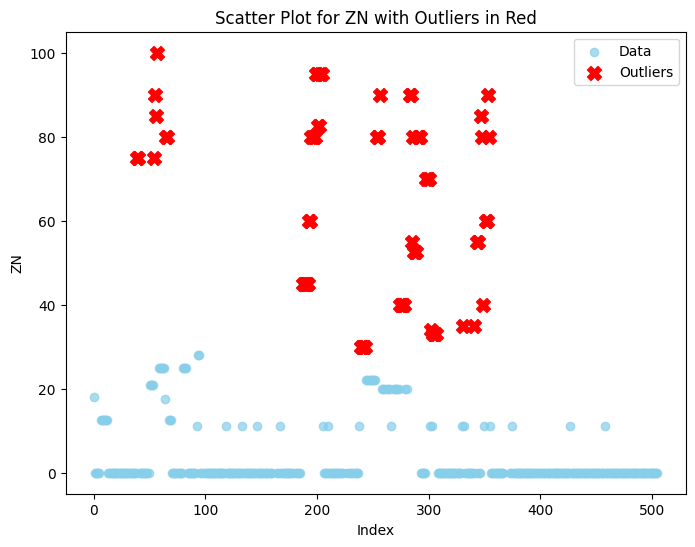


Outliers Detected for ZN:
        CRIM    ZN  INDUS  CHAS    NOX     RM   AGE      DIS  RAD  TAX  \
39   0.02763  75.0   2.95   0.0  0.428  6.595  21.8   5.4011    3  252   
40   0.03359  75.0   2.95   0.0  0.428  7.024  15.8   5.4011    3  252   
54   0.01360  75.0   4.00   0.0  0.410  5.888  47.6   7.3197    3  469   
55   0.01311  90.0   1.22   0.0  0.403  7.249  21.9   8.6966    5  226   
56   0.02055  85.0   0.74   0.0  0.410  6.383  35.7   9.1876    2  313   
..       ...   ...    ...   ...    ...    ...   ...      ...  ...  ...   
349  0.02899  40.0   1.25   0.0  0.429  6.939  34.5   8.7921    1  335   
351  0.07950  60.0   1.69   0.0  0.411  6.579  35.9  10.7103    4  411   
352  0.07244  60.0   1.69   0.0  0.411  5.884  18.5  10.7103    4  411   
353  0.01709  90.0   2.02   0.0  0.410  6.728  36.1  12.1265    5  187   
354  0.04301  80.0   1.91   0.0  0.413  5.663  21.9  10.5857    4  334   

     PTRATIO       B      LSTAT  MEDV  
39      18.3  395.63   4.320000  30.8  
40  

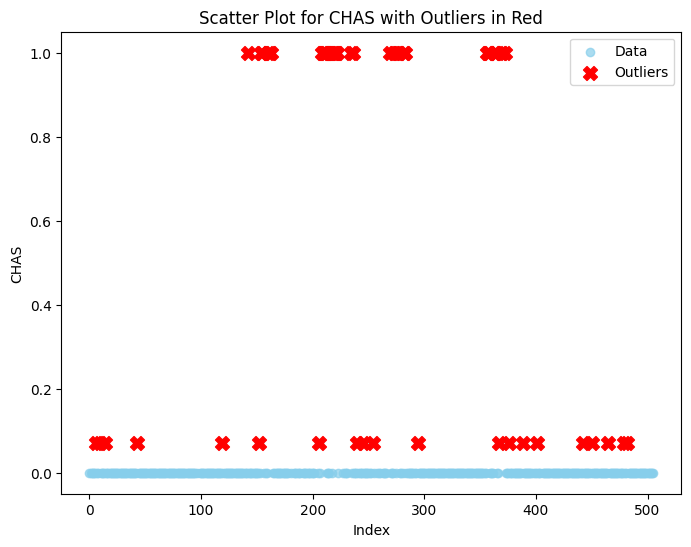


Outliers Detected for CHAS:
          CRIM         ZN      INDUS      CHAS     NOX     RM         AGE  \
6     0.088290  12.500000   7.870000  0.069959  0.5240  6.012   66.600000   
9     0.170040  12.500000   7.870000  0.069959  0.5240  6.004   85.900000   
14    0.637960   0.000000   8.140000  0.069959  0.5380  6.096   84.500000   
43    0.159360   0.000000   6.910000  0.069959  0.4480  6.211    6.500000   
119   0.144760   0.000000  10.010000  0.069959  0.5470  5.731   65.200000   
142   3.321050   0.000000  19.580000  1.000000  0.8710  5.403  100.000000   
152   1.126580   0.000000  19.580000  0.069959  0.8710  5.012   88.000000   
154   1.413850   0.000000  19.580000  1.000000  0.8710  6.129   96.000000   
155   3.535010   0.000000  19.580000  1.000000  0.8710  6.152   68.518519   
160   1.273460   0.000000  19.580000  1.000000  0.6050  6.250   92.600000   
162   1.833770   0.000000  19.580000  1.000000  0.6050  7.802   98.200000   
163   1.519020   0.000000  19.580000  1.000000 

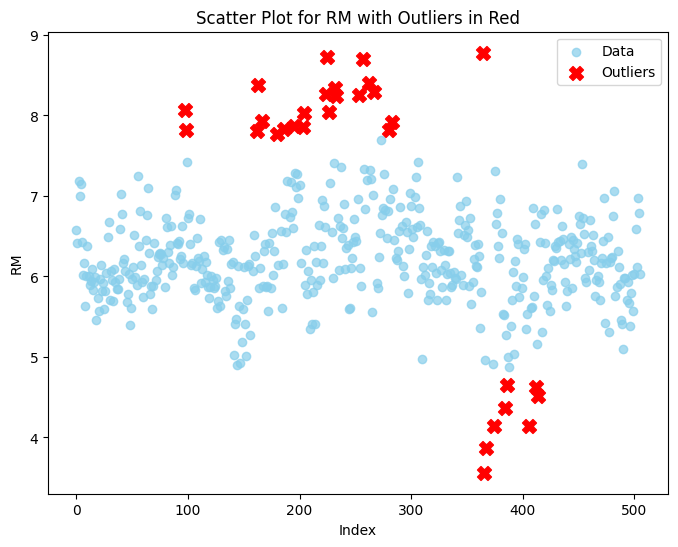


Outliers Detected for RM:
          CRIM         ZN      INDUS      CHAS     NOX     RM         AGE  \
97    0.120830   0.000000   2.890000  0.000000  0.4450  8.069   76.000000   
98    0.081870   0.000000   2.890000  0.000000  0.4450  7.820   36.900000   
162   1.833770   0.000000  19.580000  1.000000  0.6050  7.802   98.200000   
163   1.519020   0.000000  19.580000  1.000000  0.6050  8.375   68.518519   
166   2.010190   0.000000  19.580000  0.000000  0.6050  7.929   96.200000   
180   0.065880   0.000000   2.460000  0.000000  0.4880  7.765   83.300000   
186   0.056020  11.211934   2.460000  0.000000  0.4880  7.831   53.600000   
195   0.013810  80.000000   0.460000  0.000000  0.4220  7.875   32.000000   
203   0.035100  95.000000   2.680000  0.000000  0.4161  7.853   33.200000   
204   0.020090  95.000000   2.680000  0.000000  0.4161  8.034   31.900000   
224   0.315330   0.000000   6.200000  0.000000  0.5040  8.266   78.300000   
225   0.526930   0.000000   6.200000  0.000000  0

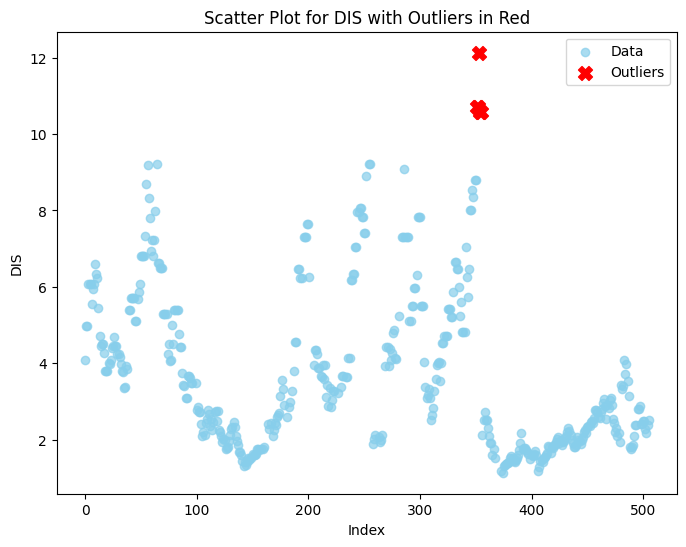


Outliers Detected for DIS:
        CRIM         ZN  INDUS  CHAS    NOX     RM        AGE      DIS  RAD  \
351  0.07950  60.000000   1.69   0.0  0.411  6.579  35.900000  10.7103    4   
352  0.07244  60.000000   1.69   0.0  0.411  5.884  18.500000  10.7103    4   
353  0.01709  90.000000   2.02   0.0  0.410  6.728  36.100000  12.1265    5   
354  0.04301  80.000000   1.91   0.0  0.413  5.663  21.900000  10.5857    4   
355  0.10659  11.211934   1.91   0.0  0.413  5.936  68.518519  10.5857    4   

     TAX  PTRATIO       B  LSTAT  MEDV  
351  411     18.3  370.78   5.49  24.1  
352  411     18.3  392.33   7.79  18.6  
353  187     17.0  384.46   4.50  30.1  
354  334     22.0  382.80   8.05  18.2  
355  334     22.0  376.04   5.57  20.6  


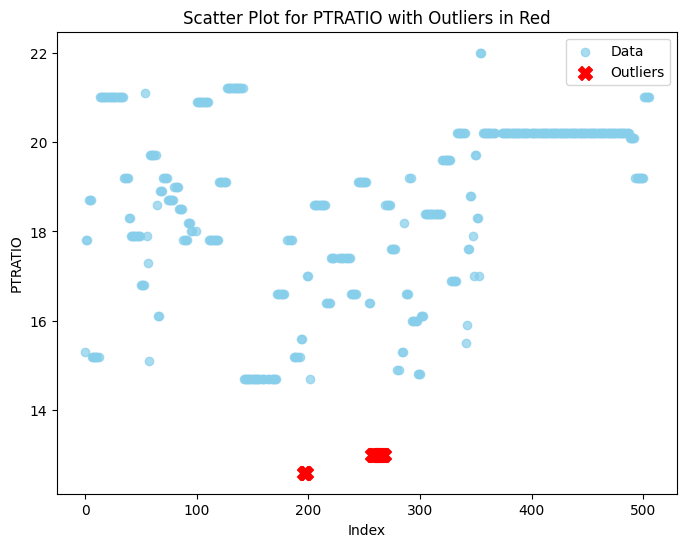


Outliers Detected for PTRATIO:
         CRIM         ZN  INDUS  CHAS    NOX     RM    AGE     DIS  RAD  TAX  \
196  3.611874  80.000000   1.52   0.0  0.404  7.287   34.1  7.3090    2  329   
197  0.046660  80.000000   1.52   0.0  0.404  7.107   36.6  7.3090    2  329   
198  0.037680  80.000000   1.52   0.0  0.404  7.274   38.3  7.3090    2  329   
257  0.611540  20.000000   3.97   0.0  0.647  8.704   86.9  1.8010    5  264   
258  0.663510  20.000000   3.97   0.0  0.647  7.333  100.0  1.8946    5  264   
259  0.656650  20.000000   3.97   0.0  0.647  6.842  100.0  2.0107    5  264   
260  0.540110  20.000000   3.97   0.0  0.647  7.203   81.8  2.1121    5  264   
261  0.534120  20.000000   3.97   0.0  0.647  7.520   89.4  2.1398    5  264   
262  3.611874  20.000000   3.97   0.0  0.647  8.398   91.5  2.2885    5  264   
263  0.825260  20.000000   3.97   0.0  0.647  7.327   94.5  2.0788    5  264   
264  0.550070  20.000000   3.97   0.0  0.647  7.206   91.6  1.9301    5  264   
265  0.7

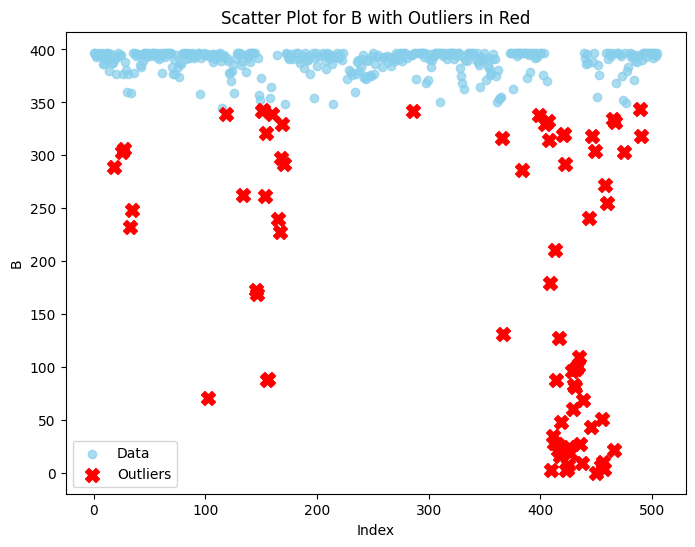


Outliers Detected for B:
        CRIM   ZN      INDUS  CHAS    NOX     RM   AGE     DIS  RAD  TAX  \
18   0.80271  0.0   8.140000   0.0  0.538  5.456  36.6  3.7965    4  307   
25   0.84054  0.0   8.140000   0.0  0.538  5.599  85.7  4.4546    4  307   
27   0.95577  0.0   8.140000   0.0  0.538  6.047  88.8  4.4534    4  307   
32   1.38799  0.0   8.140000   0.0  0.538  5.950  82.0  3.9900    4  307   
34   1.61282  0.0   8.140000   0.0  0.538  6.096  96.9  3.7598    4  307   
..       ...  ...        ...   ...    ...    ...   ...     ...  ...  ...   
466  3.77498  0.0  11.083992   0.0  0.655  5.952  84.7  2.8715   24  666   
467  4.42228  0.0  18.100000   0.0  0.584  6.003  94.5  2.5403   24  666   
475  6.39312  0.0  18.100000   0.0  0.584  6.162  97.4  2.2060   24  666   
489  0.18337  0.0  27.740000   0.0  0.609  5.414  98.3  1.7554    4  711   
490  0.20746  0.0  27.740000   0.0  0.609  5.093  98.0  1.8226    4  711   

     PTRATIO       B  LSTAT  MEDV  
18      21.0  288.99  11.

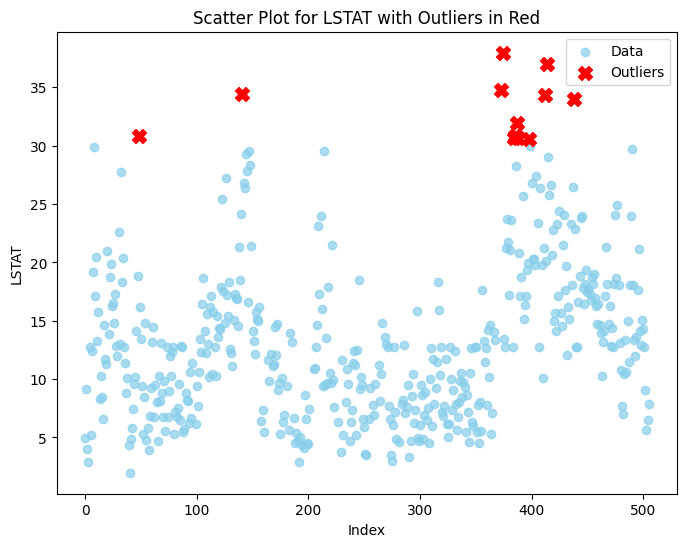


Outliers Detected for LSTAT:
         CRIM   ZN  INDUS      CHAS    NOX     RM    AGE     DIS  RAD  TAX  \
48    0.25387  0.0   6.91  0.000000  0.448  5.399   95.3  5.8700    3  233   
141   1.62864  0.0  21.89  0.000000  0.624  5.019  100.0  1.4394    4  437   
373  11.10810  0.0  18.10  0.000000  0.668  4.906  100.0  1.1742   24  666   
374  18.49820  0.0  18.10  0.000000  0.668  4.138  100.0  1.1370   24  666   
384  20.08490  0.0  18.10  0.000000  0.700  4.368   91.2  1.4395   24  666   
385  16.81180  0.0  18.10  0.000000  0.700  5.277   98.1  1.4261   24  666   
387  22.59710  0.0  18.10  0.000000  0.700  5.000   89.5  1.5184   24  666   
388  14.33370  0.0  18.10  0.069959  0.700  4.880  100.0  1.5895   24  666   
398  38.35180  0.0  18.10  0.000000  0.693  5.453  100.0  1.4896   24  666   
412  18.81100  0.0  18.10  0.000000  0.597  4.628  100.0  1.5539   24  666   
414  45.74610  0.0  18.10  0.000000  0.693  4.519  100.0  1.6582   24  666   
438  13.67810  0.0  18.10  0.00000

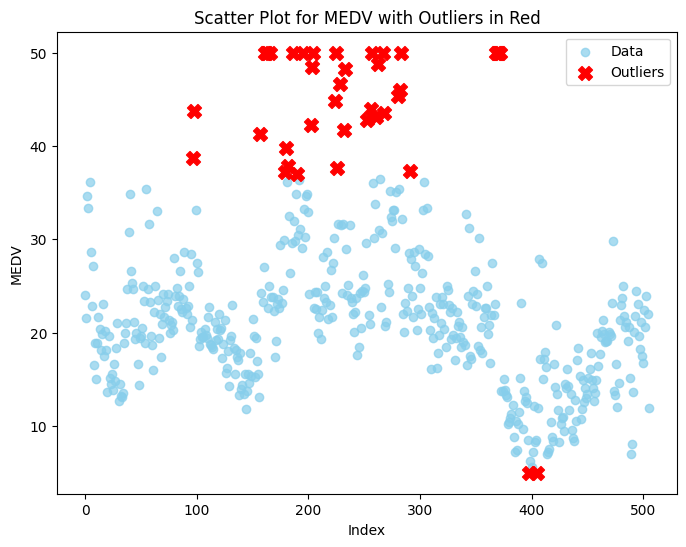


Outliers Detected for MEDV:
          CRIM         ZN  INDUS  CHAS     NOX     RM         AGE     DIS  \
97    0.120830   0.000000   2.89   0.0  0.4450  8.069   76.000000  3.4952   
98    0.081870   0.000000   2.89   0.0  0.4450  7.820   36.900000  3.4952   
157   1.223580  11.211934  19.58   0.0  0.6050  6.943   97.400000  1.8773   
161   1.463360   0.000000  19.58   0.0  0.6050  7.489   90.800000  1.9709   
162   1.833770   0.000000  19.58   1.0  0.6050  7.802   98.200000  2.0407   
163   1.519020   0.000000  19.58   1.0  0.6050  8.375   68.518519  2.1620   
166   2.010190   0.000000  19.58   0.0  0.6050  7.929   96.200000  2.0459   
179   0.057800   0.000000   2.46   0.0  0.4880  6.980   58.400000  2.8290   
180   0.065880   0.000000   2.46   0.0  0.4880  7.765   83.300000  2.7410   
182   0.091030   0.000000   2.46   0.0  0.4880  7.155   92.200000  2.7006   
186   0.056020  11.211934   2.46   0.0  0.4880  7.831   53.600000  3.1992   
190   0.090680  45.000000   3.44   0.0  0.4370 

In [11]:
# Generate scatter plots only for the columns that contain outliers
for feature in outlier_columns:
    plt.figure(figsize=(8, 6))
    non_outliers = data[~outlier_mask]  # Data without outliers
    plt.scatter(non_outliers.index, non_outliers[feature], color='skyblue', label="Data", alpha=0.7)
    outliers = outliers_dict[feature]
    plt.scatter(outliers.index, outliers[feature], color='red', label="Outliers", s=100, marker='X')
    plt.title(f"Scatter Plot for {feature} with Outliers in Red")
    plt.xlabel('Index')
    plt.ylabel(feature)
    plt.legend()
    plt.show()
    print(f"\nOutliers Detected for {feature}:")
    print(outliers)

In [12]:
# Visualize the original data with a pairplot (including outliers)
sns.pairplot(data, hue='CRIM', plot_kws={'alpha': 0.5})
plt.suptitle("Pairplot of Features with CRIM Class Labels (Including Outliers)", y=1.02)
plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [13]:
# Remove the outliers from the dataset

cleaned_data = data.copy()

In [14]:
# Loop through outlier columns to remove outliers
for feature in outlier_columns:
    outliers = outliers_dict[feature]  # Get outliers for the current feature
    cleaned_data = cleaned_data[~cleaned_data.index.isin(outliers.index)]  # Remove rows with outliers


In [15]:
# Visualize the cleaned data with a pairplot (after removing outliers)
sns.pairplot(cleaned_data, hue='CRIM', plot_kws={'alpha': 0.5})
plt.suptitle("Pairplot of Features with CRIM Class Labels (After Removing Outliers)", y=1.02)
plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [16]:
# Step 7: Preprocess the data (encoding and scaling)
label_encoder = LabelEncoder()
data['CRIM'] = label_encoder.fit_transform(data['CRIM'])

for column in data.select_dtypes(include=['object']).columns:
    if column != 'CRIM':
        label_encoder = LabelEncoder()
        data[column] = label_encoder.fit_transform(data[column])

X = data.drop(columns=['CRIM'])  # Features
y = data['CRIM']  # Target variable

In [17]:
# Step 8: Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [18]:
# Step 9: Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [19]:
# Step 10: Model selection and training
logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(X_train, y_train)


LogisticRegression(max_iter=1000)

In [20]:
tree_model = DecisionTreeClassifier(random_state=42)
tree_model.fit(X_train, y_train)


DecisionTreeClassifier(random_state=42)

In [21]:
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [22]:
# Step 11: Model evaluation
models = {
    "Logistic Regression": logistic_model,
    "Decision Tree": tree_model,
    "Random Forest": rf_model
}

accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
conf_matrices = {}
class_reports = {}


In [23]:
for model_name, model in models.items():
    pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred, average="weighted")
    recall = recall_score(y_test, pred, average="weighted")
    f1 = f1_score(y_test, pred, average="weighted")
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    conf_matrices[model_name] = confusion_matrix(y_test, pred)
    class_reports[model_name] = classification_report(y_test, pred)

In [24]:
metrics_df = pd.DataFrame({
    "Model": list(models.keys()),
    "Accuracy": accuracy_scores,
    "Precision": precision_scores,
    "Recall": recall_scores,
    "F1 Score": f1_scores
})


In [25]:
metrics_melted = metrics_df.melt(id_vars="Model", var_name="Metric", value_name="Score")


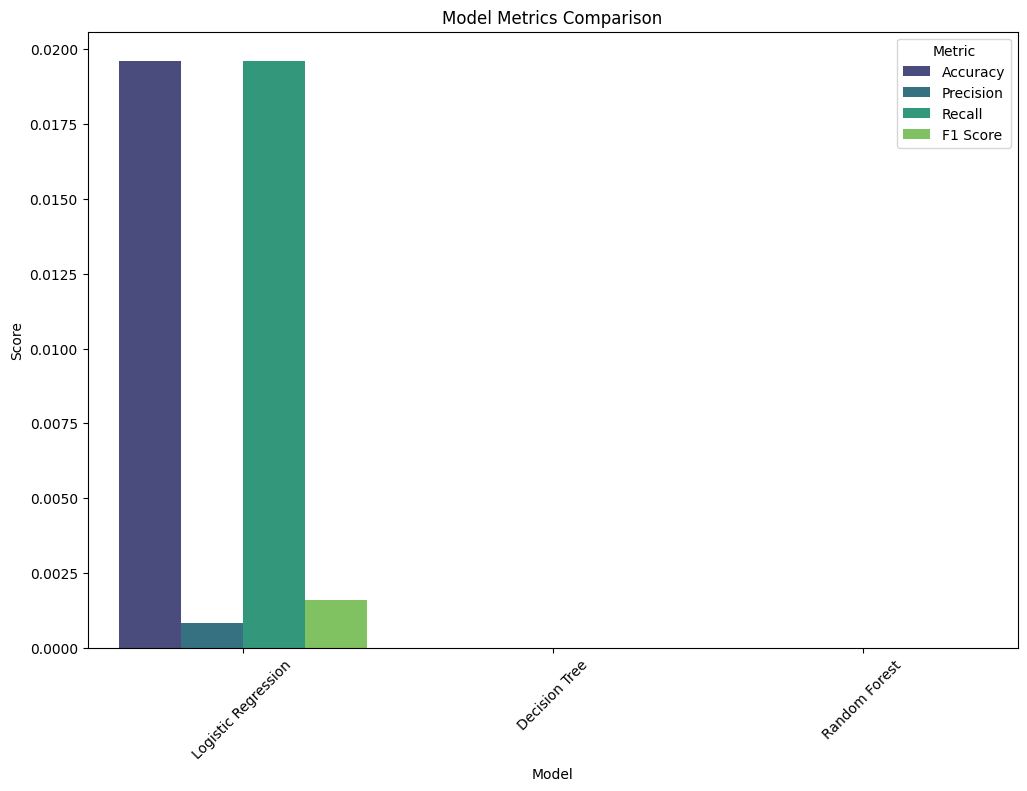

In [26]:
plt.figure(figsize=(12, 8))
sns.barplot(data=metrics_melted, x="Model", y="Score", hue="Metric", palette="viridis")
plt.title("Model Metrics Comparison")
plt.xlabel("Model")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.legend(title="Metric")
plt.show()

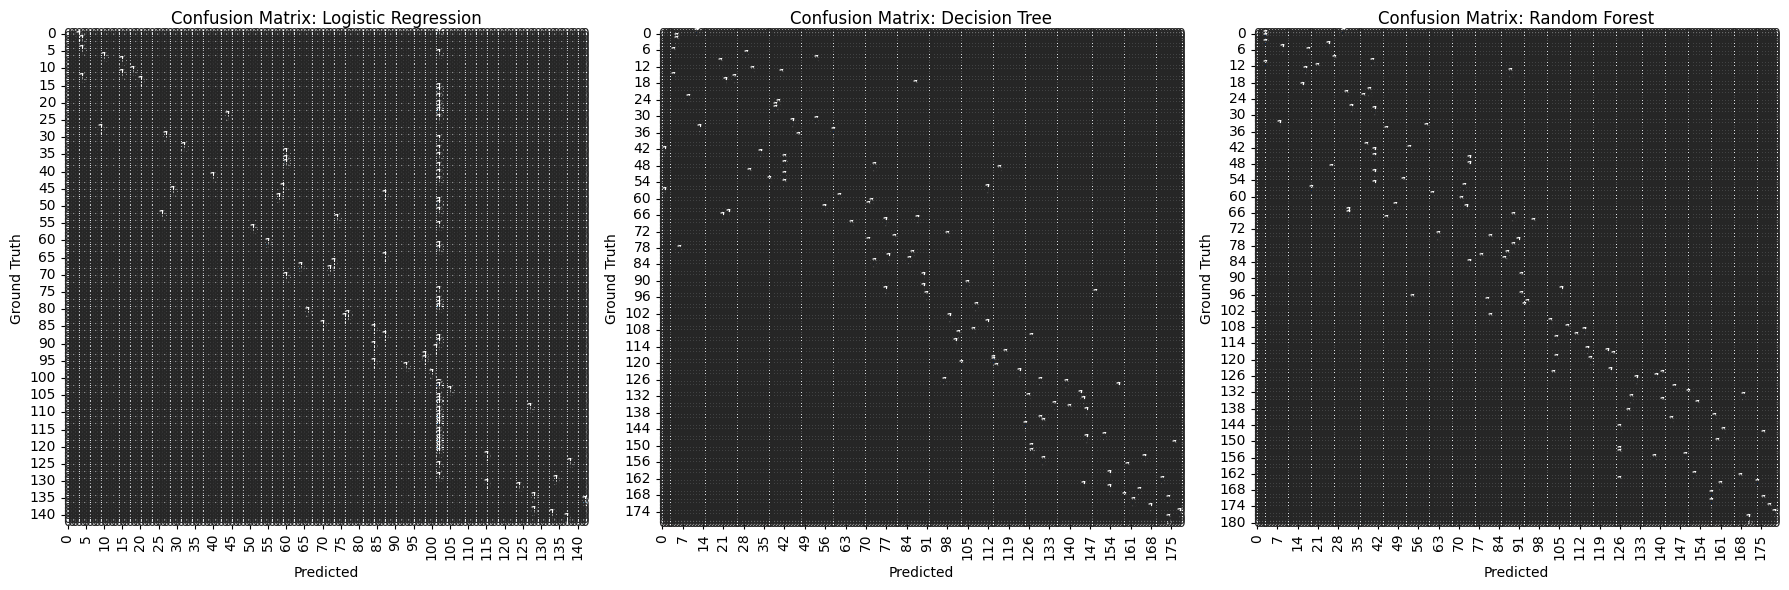

In [27]:
# Plot confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
for i, (model_name, cm) in enumerate(conf_matrices.items()):
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", ax=axes[i], cbar=False)
    axes[i].set_title(f"Confusion Matrix: {model_name}")
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("Ground Truth")

plt.tight_layout()
plt.show()

In [28]:
# Display classification reports
for model_name, report in class_reports.items():
    print(f"\nClassification Report for {model_name}:\n{report}")



Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         0
          16       0.00      0.00      0.00         1
          22       0.00      0.00      0.00         1
          24       0.00      0.00      0.00         1
          25       0.00      0.00      0.00         1
          30       0.00      0.00      0.00         0
          34       0.00      0.00      0.00         0
          35       0.00      0.00      0.00         1
          38       0.00      0.00      0.00         1
          39       0.00      0.00      0.00         1
          41       0.00      0.00      0.00         1
          45       0.00      0.00      0.00         0
          46       0.00      0.00